* In this section we are trying to predict the surface air temperature map using gridded satellite and reanalysis greenhouse gases (CO2, CH4, N2O) dataset.
* Models used for this investigation include CNN (Convolutional Neural Network)and CNN-LSTM.
* Codes are runned after the submission of report therefore some of the values might have difference with the written report.

### Settings

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install netCDF4 h5py

In [ ]:
!pip install keras-tuner --upgrade

In [ ]:
#Libraries
import netCDF4 as nc
import h5py
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

#Dataset
from sklearn.model_selection import train_test_split

#CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, GlobalAveragePooling2D, Dense, Activation, Reshape, TimeDistributed, Conv2D, MaxPooling2D, LSTM, Dense, Flatten
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow import keras

#hyperparamete tuning
import keras_tuner

* Dataset
  - organized_data_final.nc is data organized dataset containing CO2, CH4, N2O monthly values from 2015.01 ~ 2022.02.
  - Specific process of how datasets are achieved and are preprocessed are written in "Settings/Visualization" file.


In [ ]:
%cd /content/drive/MyDrive

In [ ]:
all_data = nc.Dataset('organized_data_final.nc')

In [ ]:
variable_names = all_data.variables.keys()
print(variable_names)

In [ ]:
for var_name in variable_names:
    var = all_data.variables[var_name]
    data_type = var.dtype
    data_structure = var.shape
    print(f"Variable Name: {var_name}, Data Type: {data_type}, Data Structure : {data_structure}")

In [ ]:
co2 = all_data.variables['co2_data'][:]
ch4 = all_data.variables['ch4_data'][:]
n2o = all_data.variables['n2o_data'][:]
temp = all_data.variables['temp_data'][:]
year_month = all_data.variables['year_month'][:]

In [ ]:
year_month

# Datasets
- We wish to see how gridded greenhouse gas datasets can effectively estimate surface temperature datasets.
- For Model 1, all CO2, CH4, N2O datasets are combined.

In [ ]:
# Combine datsets (CO2, CH4, N2O)
data_combined = np.stack([co2, ch4, n2o], axis=-1)

In [ ]:
data_combined.shape

(86, 180, 360, 3)

* Predictand

In [ ]:
temp.shape

(86, 180, 360)

# Models

## 1) Convolutional Neural Networks

In [ ]:
# Split data (train, test)
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(data_combined, temp, test_size=0.15, random_state=42)

In [ ]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()
mean2, std2 = y_train_df.mean(), y_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std
y_train_df   = (y_train_df - mean2)/std2
y_test_df    = (y_test_df - mean2)/std2

X_train = X_train_df
X_test = X_test_df
y_train = y_train_df
y_test = y_test_df

In [ ]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(73, 180, 360, 3) (73, 180, 360) (13, 180, 360, 3) (13, 180, 360)


* Code reference from https://github.com/leap-stc/EAEE4000_ML_for_Env_Eng_Sci

In [ ]:
n_filters   = 20 # number of filters
kernel_size = 3  # kernel size for Covolutional layers
pool_size   = 2  # size for average pooling layers
activation  = 'relu' # activation function
learning_rate = 0.001 # learning rate
minibatch_size = 10   # batch size
num_epochs     = 300   # number of total epochs

In [ ]:
n_lat,n_lon,n_feature = data_combined.shape[1:]

In [ ]:
n_feature

3

In [ ]:
model_cnn = Sequential()

model_cnn.add(Input(shape=(n_lat, n_lon, n_feature)))
model_cnn.add(Conv2D(n_filters, (kernel_size, kernel_size), padding='same', activation=activation))
model_cnn.add(AveragePooling2D(pool_size))
model_cnn.add(GlobalAveragePooling2D())
model_cnn.add(Dense(n_lat * n_lon))
model_cnn.add(Activation('linear'))
model_cnn.add(Reshape((1, n_lat, n_lon)))

model_cnn.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 360, 20)      560       
                                                                 
 average_pooling2d (Average  (None, 90, 180, 20)       0         
 Pooling2D)                                                      
                                                                 
 global_average_pooling2d (  (None, 20)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 64800)             1360800   
                                                                 
 activation (Activation)     (None, 64800)             0         
                                                                 
 reshape (Reshape)           (None, 1, 180, 360)       0

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model_cnn.fit(X_train, y_train,
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    validation_split=0.2, verbose=1,
                    callbacks=[early_stop])

Epoch 1/300
6/6 [==============================] - 5s 148ms/step - loss: 0.7876 - val_loss: 0.7754
Epoch 2/300
6/6 [==============================] - 0s 19ms/step - loss: 0.7520 - val_loss: 0.7317
Epoch 3/300
6/6 [==============================] - 0s 19ms/step - loss: 0.7030 - val_loss: 0.6739
Epoch 4/300
6/6 [==============================] - 0s 19ms/step - loss: 0.6402 - val_loss: 0.6029
Epoch 5/300
6/6 [==============================] - 0s 20ms/step - loss: 0.5659 - val_loss: 0.5237
Epoch 6/300
6/6 [==============================] - 0s 18ms/step - loss: 0.4874 - val_loss: 0.4381
Epoch 7/300
6/6 [==============================] - 0s 19ms/step - loss: 0.4026 - val_loss: 0.3555
Epoch 8/300
6/6 [==============================] - 0s 18ms/step - loss: 0.3278 - val_loss: 0.2985
Epoch 9/300
6/6 [==============================] - 0s 20ms/step - loss: 0.2971 - val_loss: 0.2878
Epoch 10/300
6/6 [==============================] - 0s 18ms/step - loss: 0.2763 - val_loss: 0.2570
Epoch 11/300
6/6 [

In [ ]:
loss = model_cnn.evaluate(X_test, y_test)
print(f'Mean Averaged Error on Test Data: {loss}')

1/1 [==============================] - 0s 166ms/step - loss: 0.2158
Mean Squared Error on Test Data: 0.21577061712741852


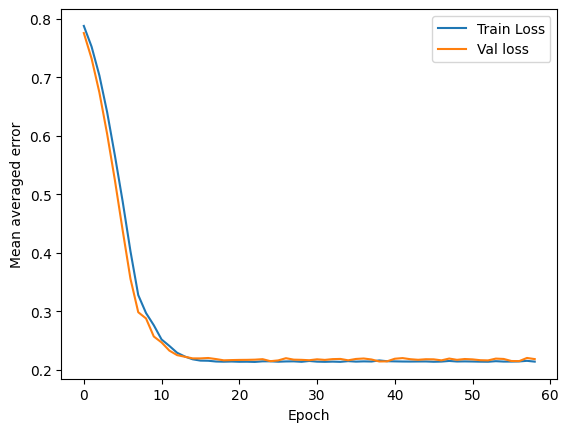

In [ ]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean averaged error')
plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
plt.legend()

## Testing model

In [ ]:
y_pred = model_cnn.predict(X_test)

1/1 [==============================] - 0s 147ms/step


In [ ]:
y_pred_reshaped = y_pred.reshape((y_test.shape[0], 180, 360))

In [ ]:
y_pred_reshaped.shape

(13, 180, 360)

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test[0], y_pred_reshaped[0])
print(f"R^2 Score: {r2}")

R^2 Score: 0.9831025696805518


In [ ]:
#Change of scale
y_test_original_scale = (y_test * std2) + mean2
y_pred_original_scale = (y_pred_reshaped * std2) + mean2

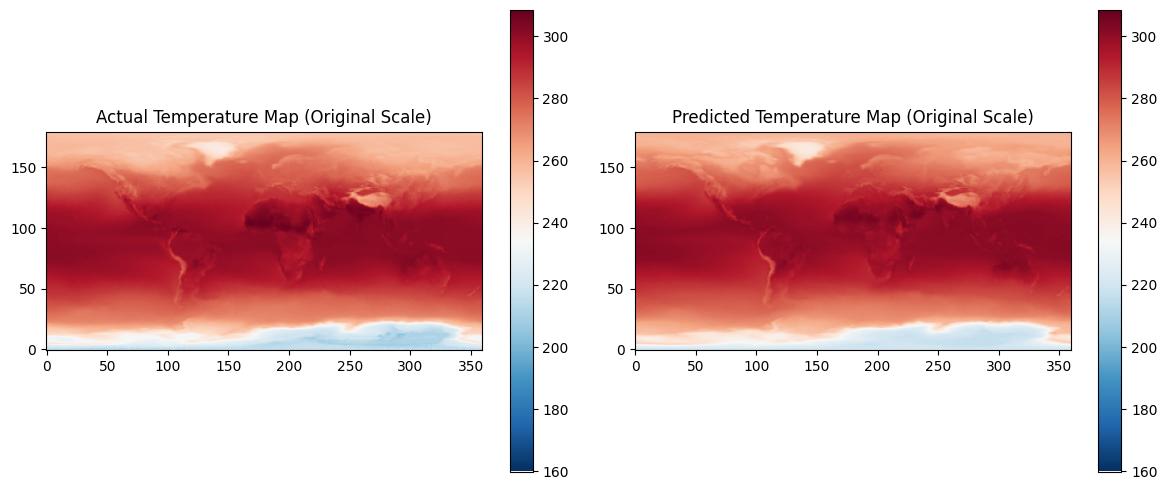

In [ ]:
import matplotlib.pyplot as plt

time_step_index = 0


# Determine the common color scale limits based on the actual data
common_vmin = min(y_test_original_scale[time_step_index].min(), y_pred_original_scale[time_step_index].min())
common_vmax = max(y_test_original_scale[time_step_index].max(), y_pred_original_scale[time_step_index].max())

# Plot actual temperature map
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(y_test_original_scale[time_step_index].reshape((180, 360)), cmap='RdBu_r', vmin=160, vmax=common_vmax)
plt.title('Actual Temperature Map (Original Scale)')
plt.gca().invert_yaxis()
plt.colorbar()

# Plot predicted temperature map
plt.subplot(1, 2, 2)
plt.imshow(y_pred_original_scale[time_step_index], cmap='RdBu_r', vmin=160, vmax=common_vmax)
plt.title('Predicted Temperature Map (Original Scale)')
plt.colorbar()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

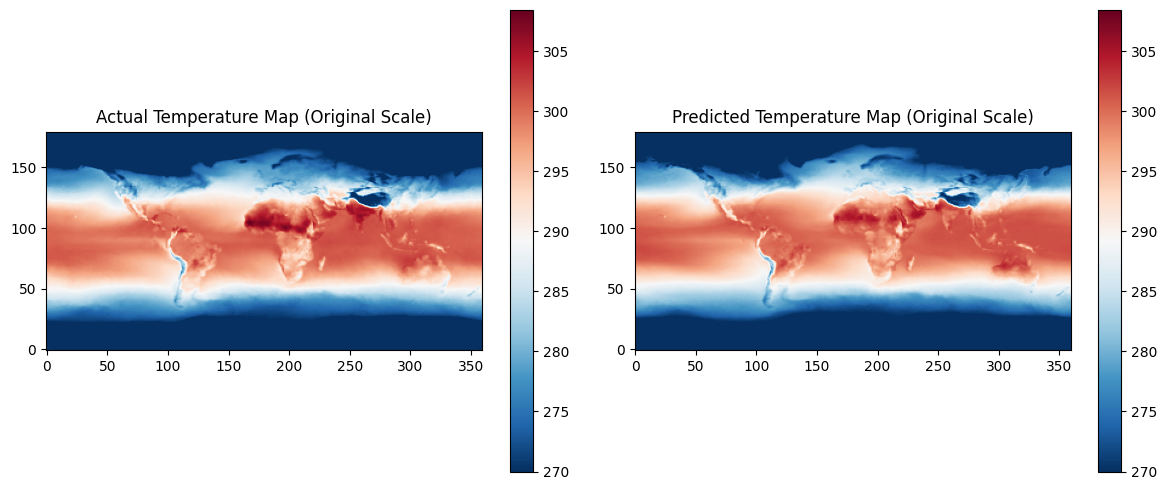

In [ ]:
import matplotlib.pyplot as plt

time_step_index = 0


# Determine the common color scale limits based on the actual data
common_vmin = min(y_test_original_scale[time_step_index].min(), y_pred_original_scale[time_step_index].min())
common_vmax = max(y_test_original_scale[time_step_index].max(), y_pred_original_scale[time_step_index].max())

# Plot actual temperature map
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(y_test_original_scale[time_step_index].reshape((180, 360)), cmap='RdBu_r', vmin=270, vmax=common_vmax)
plt.title('Actual Temperature Map (Original Scale)')
plt.gca().invert_yaxis()
plt.colorbar()

# Plot predicted temperature map
plt.subplot(1, 2, 2)
plt.imshow(y_pred_original_scale[time_step_index], cmap='RdBu_r', vmin=270, vmax=common_vmax)
plt.title('Predicted Temperature Map (Original Scale)')
plt.colorbar()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

* Hyperparameter tuning Code reference from https://github.com/leap-stc/EAEE4000_ML_for_Env_Eng_Sci

In [ ]:
num_epochs     = 80
n_trials       = 10   # total number of trials in hyperparameter tuning
n_filters   = 20 # number of filters
kernel_size = 3  # kernel size for Covolutional layers
#pool_size   = 2  # size for average pooling layers
activation  = 'relu' # activation function
learning_rate = 0.001 # learning rate
minibatch_size = 10   # batch size
num_epochs     = 300   # number of total epochs

In [ ]:
def build_model(hp):

    # options for hyperparameters
    hp_filters = hp.Choice('filters', values=[16,32,64])
    hp_kernel_size = hp.Choice('kernel_size', values=[2,3,4,5])
    hp_pool_size = hp.Choice('pool_size', values=[2,3,4,5])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss = hp.Choice('loss', values=['mse','mae'])

    # build CNN models according to the hyperparameters
    model_cnn = keras.models.Sequential()

    model_cnn.add(Input(shape=(n_lat, n_lon, n_feature)))
    model_cnn.add(Conv2D(hp_filters, kernel_size=hp_kernel_size, padding='same', activation=hp_activation))
    model_cnn.add(AveragePooling2D(hp_pool_size))
    model_cnn.add(GlobalAveragePooling2D())
    model_cnn.add(Dense(n_lat * n_lon))
    model_cnn.add(Activation('linear'))
    model_cnn.add(Reshape((1, n_lat, n_lon)))

    model_cnn.compile(loss=hp_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))

    return model_cnn


In [ ]:
# Instantiate the Tuner and save the trials in a directory with customized project name
random_tuner = keras_tuner.RandomSearch(build_model,
                                        max_trials=n_trials,
                                        seed=5,
                                        objective='val_loss',
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=3,
                                        directory='random_search',
                                        project_name='random_search_CNN_10trial')

Reloading Tuner from random_search/random_search_CNN_10trial/tuner0.json


In [ ]:
random_tuner.search_space_summary()

Search space summary
Default search space size: 6
filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
pool_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}
loss (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae'], 'ordered': False}


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# Perform hypertuning
random_tuner.search(X_train, y_train,
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    validation_split = 0.2,
                    callbacks = [early_stop])

Trial 10 Complete [00h 01m 23s]
val_loss: 61319.7265625

Best val_loss So Far: 4.675776958465576
Total elapsed time: 01h 14m 58s


In [ ]:
# display the model structure with the best tuning
best_model = random_tuner.get_best_models()[0]
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 360, 32)      1632      
                                                                 
 average_pooling2d (Average  (None, 90, 180, 32)       0         
 Pooling2D)                                                      
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 64800)             2138400   
                                                                 
 activation (Activation)     (None, 64800)             0         
                                                                 
 reshape (Reshape)           (None, 1, 180, 360)       0

In [ ]:
# check hyperparameters of the all tuning trials
all_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)

# print the hyperparameters of the top 3 tuning trials
for it in range(3):
    print("Ranking #", str(it+1).zfill(1), "of best tuning, total trials = ", str(n_trials))
    print(all_hps[it].values)
    print("=============================================================================================")


# get the hyperparameters of the best tuning trial
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]

# get the hyperparameters of the second ranking tuning trial
top2_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[1]

Ranking # 1 of best tuning, total trials =  10
{'filters': 32, 'kernel_size': 5, 'pool_size': 2, 'activation': 'sigmoid', 'learning_rate': 0.01, 'loss': 'mae'}
Ranking # 2 of best tuning, total trials =  10
{'filters': 32, 'kernel_size': 2, 'pool_size': 4, 'activation': 'sigmoid', 'learning_rate': 0.01, 'loss': 'mae'}
Ranking # 3 of best tuning, total trials =  10
{'filters': 32, 'kernel_size': 4, 'pool_size': 2, 'activation': 'tanh', 'learning_rate': 0.01, 'loss': 'mae'}


In [ ]:
## Build the model with the optimal hyperparameters
# ---------- best tuning ----------
model_best = random_tuner.hypermodel.build(best_hps)

# ---------- ranking #2 tuning ----------
model_top2 = random_tuner.hypermodel.build(top2_hps)



## re-train the model
# ---------- best tuning ----------
history_best = model_best.fit(X_train, y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2,
                              verbose         = 1,
                              callbacks       = [early_stop])
# ---------- ranking #2 tuning ----------
history_top2 = model_top2.fit(X_train, y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2,
                              verbose         = 1,
                              callbacks       = [early_stop])


Epoch 1/300
6/6 [==============================] - 1s 59ms/step - loss: 278.1298 - val_loss: 276.6242
Epoch 2/300
6/6 [==============================] - 0s 27ms/step - loss: 276.3241 - val_loss: 274.5919
Epoch 3/300
6/6 [==============================] - 0s 27ms/step - loss: 274.3169 - val_loss: 272.6022
Epoch 4/300
6/6 [==============================] - 0s 25ms/step - loss: 272.3221 - val_loss: 270.5994
Epoch 5/300
6/6 [==============================] - 0s 26ms/step - loss: 270.3159 - val_loss: 268.5898
Epoch 6/300
6/6 [==============================] - 0s 26ms/step - loss: 268.3059 - val_loss: 266.5804
Epoch 7/300
6/6 [==============================] - 0s 24ms/step - loss: 266.2975 - val_loss: 264.5741
Epoch 8/300
6/6 [==============================] - 0s 26ms/step - loss: 264.2929 - val_loss: 262.5721
Epoch 9/300
6/6 [==============================] - 0s 24ms/step - loss: 262.2927 - val_loss: 260.5745
Epoch 10/300
6/6 [==============================] - 0s 25ms/step - loss: 260.2966 

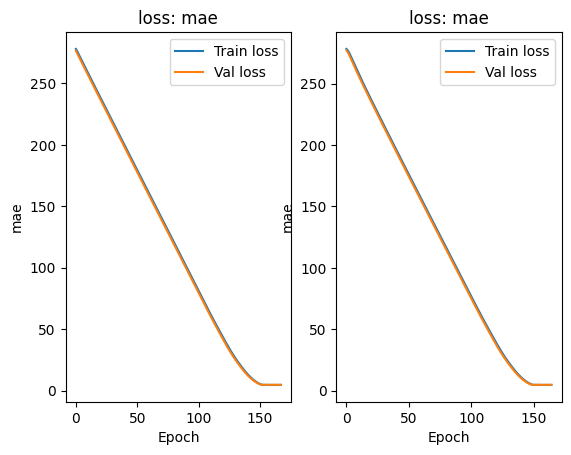

In [ ]:
## set up title and ylabel strings
# ---------- best tuning ----------
title_best = 'loss: '+str(best_hps['loss'])
ylabel_best = best_hps['loss']
# ---------- ranking #2 tuning ----------
title_top2 = 'loss: '+str(top2_hps['loss'])
ylabel_top2 = top2_hps['loss']


## plot history
# ---------- best tuning ----------
plt.subplot(1, 2, 1)
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title(title_best, fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

# ---------- ranking #2 tuning ----------
plt.subplot(1, 2, 2)
plt.plot(history_top2.history['loss'])
plt.plot(history_top2.history['val_loss'])
plt.title(title_top2, fontsize=12)
plt.ylabel(ylabel_top2)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')


## Testing model

In [ ]:
y_pred = model_best.predict(X_test)

1/1 [==============================] - 0s 268ms/step


In [ ]:
y_pred.shape

(13, 1, 180, 360)

In [ ]:
y_pred_reshaped = y_pred.reshape((y_test.shape[0], 180, 360))

In [ ]:
y_pred_reshaped.shape

(13, 180, 360)

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test[0], y_pred_reshaped[0])
print(f"R^2 Score: {r2}")

R^2 Score: 0.9733068242542272


In [ ]:
#Change of scale
y_test_original_scale = (y_test * std2) + mean2
y_pred_original_scale = (y_pred_reshaped * std2) + mean2

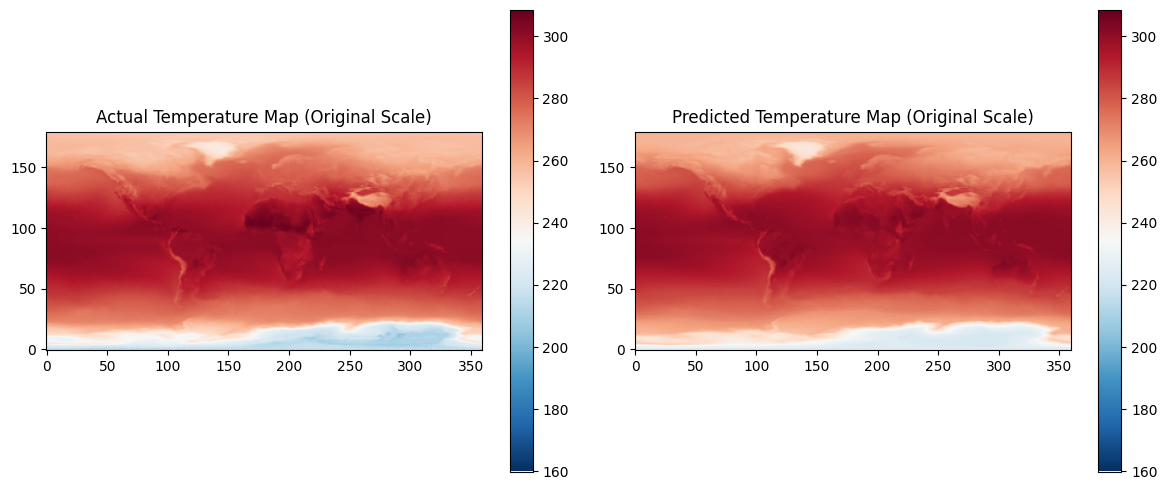

In [ ]:
import matplotlib.pyplot as plt

# Choose a time step to visualize (e.g., first time step)
time_step_index = 0


# Determine the common color scale limits based on the actual data
common_vmin = min(y_test_original_scale[time_step_index].min(), y_pred_original_scale[time_step_index].min())
common_vmax = max(y_test_original_scale[time_step_index].max(), y_pred_original_scale[time_step_index].max())

# Plot actual temperature map
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(y_test_original_scale[time_step_index].reshape((180, 360)), cmap='RdBu_r', vmin=160, vmax=common_vmax)
plt.title('Actual Temperature Map (Original Scale)')
plt.gca().invert_yaxis()
plt.colorbar()

# Plot predicted temperature map
plt.subplot(1, 2, 2)
plt.imshow(y_pred_original_scale[time_step_index], cmap='RdBu_r', vmin=160, vmax=common_vmax)
plt.title('Predicted Temperature Map (Original Scale)')
plt.colorbar()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

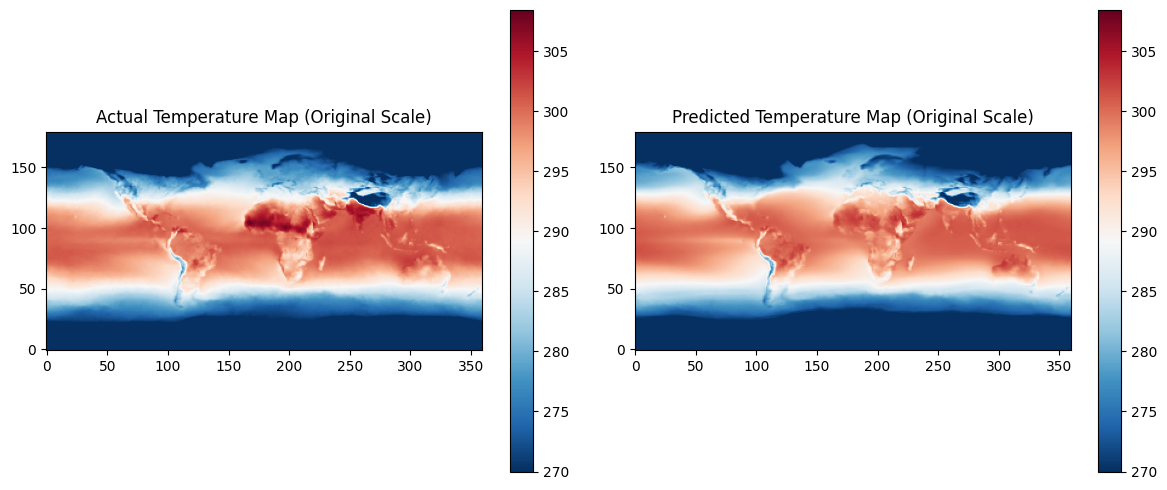

In [ ]:
import matplotlib.pyplot as plt

# Choose a time step to visualize (e.g., first time step)
time_step_index = 0


# Determine the common color scale limits based on the actual data
common_vmin = min(y_test_original_scale[time_step_index].min(), y_pred_original_scale[time_step_index].min())
common_vmax = max(y_test_original_scale[time_step_index].max(), y_pred_original_scale[time_step_index].max())

# Plot actual temperature map
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(y_test_original_scale[time_step_index].reshape((180, 360)), cmap='RdBu_r', vmin=270, vmax=common_vmax)
plt.title('Actual Temperature Map (Original Scale)')
plt.gca().invert_yaxis()
plt.colorbar()

# Plot predicted temperature map
plt.subplot(1, 2, 2)
plt.imshow(y_pred_original_scale[time_step_index], cmap='RdBu_r', vmin=270, vmax=common_vmax)
plt.title('Predicted Temperature Map (Original Scale)')
plt.colorbar()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 2) CNN - LSTM


In [2]:
X = data_combined
y = temp

NameError: ignored

In [3]:
total_samples = X.shape[0]
sequence_length = 10

# Create sequences with a sliding window
sequences_X = [X[i:i + sequence_length] for i in range(total_samples - sequence_length + 1)]
sequences_y = [y[i + sequence_length - 1:i + sequence_length] for i in range(total_samples - sequence_length + 1)]

# Convert to NumPy arrays
X = np.array(sequences_X)
y = np.array(sequences_y)

# Split the data into training and testing sets while preserving temporal order
split_index = int(0.8 * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape y_train and y_test
#y_train = y_train.reshape((y_train.shape[0], 1, y_train.shape[1], y_train.shape[2]))
#y_test = y_test.reshape((y_test.shape[0], 1, y_test.shape[1], y_test.shape[2]))


NameError: ignored

In [ ]:
# Standardization
mean, std = X_train.mean(), X_train.std()
mean2, std2 = y_train.mean(), y_train.std()

X_train   = (X_train - mean)/std
X_test   = (X_test - mean)/std
y_train  = (y_train - mean2)/std2
y_test   = (y_test - mean2)/std2

#X_train = X_train_df
#X_test = X_test_df
#y_train = y_train_df
#y_test = y_test_df

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
n_filters   = 20 # number of filters
kernel_size = 3  # kernel size for Covolutional layers
pool_size   = 2  # size for average pooling layers
n_lstm_unit = 25 # number of LSTM units
activation  = 'relu' # activation function
learning_rate = 0.001 # learning rate
minibatch_size = 64   # batch size
num_epochs     = 50   # number of total epochs\
n_lat = 180
n_lon = 360
n_feature = 3

In [ ]:
### model using mse as loss function
model_mse = Sequential()

model_mse.add(Input(shape=(sequence_length, n_lat,n_lon,n_feature)))
model_mse.add(TimeDistributed(Conv2D(n_filters, (kernel_size, kernel_size), padding='same', activation=activation), input_shape=(sequence_length, n_lat,n_lon,n_feature)))
model_mse.add(TimeDistributed(AveragePooling2D(pool_size)))
model_mse.add(TimeDistributed(GlobalAveragePooling2D()))
model_mse.add(LSTM(n_lstm_unit, activation=activation))
model_mse.add(Dense(n_lat*n_lon))
model_mse.add(Activation('linear'))
model_mse.add(Reshape((1, n_lat, n_lon)))


model_mse.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model_mse.summary()

In [ ]:
# Train the model
model_mse.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.2)

## Testing model

In [ ]:
y_pred = model_mse.predict(X_test)

1/1 [==============================] - 1s 577ms/step


In [ ]:
y_pred.shape

(16, 1, 180, 360)

In [ ]:
y_pred_reshaped = y_pred.reshape((y_test.shape[0], 180, 360))
y_test_reshaped= y_test.reshape((y_test.shape[0], 180, 360))

In [ ]:
y_pred_reshaped.shape

(16, 180, 360)

In [ ]:
y_test.shape

(16, 1, 180, 360)

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_reshaped[0], y_pred_reshaped[0])
print(f"R^2 Score: {r2}")

R^2 Score: 0.9339519284505788


In [ ]:
#Change of scale
y_test_original_scale = (y_test_reshaped * std2) + mean2
y_pred_original_scale = (y_pred_reshaped * std2) + mean2

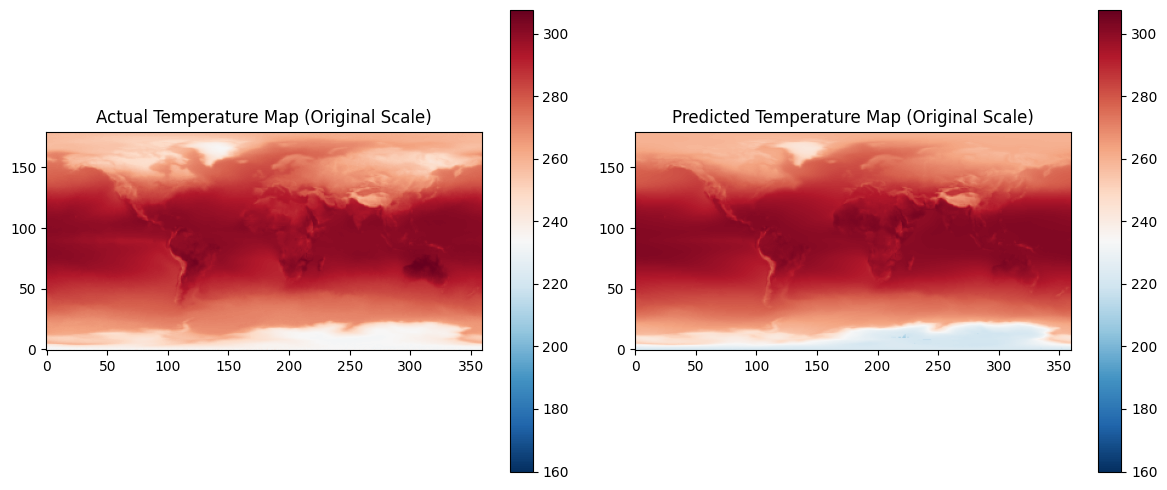

In [ ]:
import matplotlib.pyplot as plt

# Choose a time step to visualize (e.g., first time step)
time_step_index = 0


# Determine the common color scale limits based on the actual data
common_vmin = min(y_test_original_scale[time_step_index].min(), y_pred_original_scale[time_step_index].min())
common_vmax = max(y_test_original_scale[time_step_index].max(), y_pred_original_scale[time_step_index].max())

# Plot actual temperature map
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(y_test_original_scale[time_step_index].reshape((180, 360)), cmap='RdBu_r', vmin=160, vmax=common_vmax)
plt.title('Actual Temperature Map (Original Scale)')
plt.gca().invert_yaxis()
plt.colorbar()

# Plot predicted temperature map
plt.subplot(1, 2, 2)
plt.imshow(y_pred_original_scale[time_step_index], cmap='RdBu_r', vmin=160, vmax=common_vmax)
plt.title('Predicted Temperature Map (Original Scale)')
plt.colorbar()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

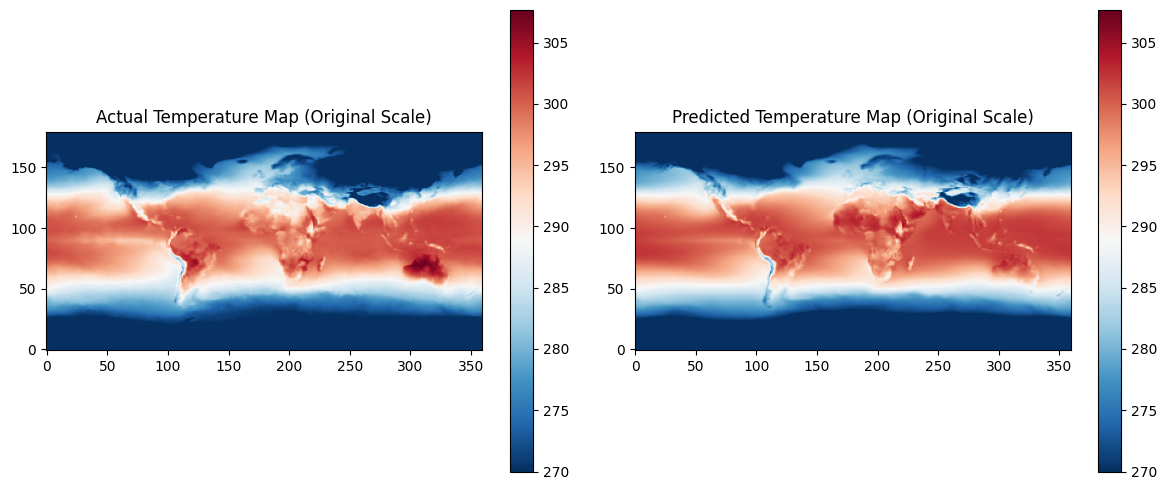

In [ ]:
import matplotlib.pyplot as plt

# Choose a time step to visualize (e.g., first time step)
time_step_index = 0


# Determine the common color scale limits based on the actual data
common_vmin = min(y_test_original_scale[time_step_index].min(), y_pred_original_scale[time_step_index].min())
common_vmax = max(y_test_original_scale[time_step_index].max(), y_pred_original_scale[time_step_index].max())

# Plot actual temperature map
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(y_test_original_scale[time_step_index].reshape((180, 360)), cmap='RdBu_r', vmin=270, vmax=common_vmax)
plt.title('Actual Temperature Map (Original Scale)')
plt.gca().invert_yaxis()
plt.colorbar()

# Plot predicted temperature map
plt.subplot(1, 2, 2)
plt.imshow(y_pred_original_scale[time_step_index], cmap='RdBu_r', vmin=270, vmax=common_vmax)
plt.title('Predicted Temperature Map (Original Scale)')
plt.colorbar()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## CNN-LSTM Hyperparameter Tuning

* Code reference from https://github.com/leap-stc/EAEE4000_ML_for_Env_Eng_Sci

In [ ]:
num_epochs     = 80
n_trials       = 10   # total number of trials in hyperparameter tuning
n_filters   = 20 # number of filters
kernel_size = 3  # kernel size for Covolutional layers
activation  = 'relu' # activation function
learning_rate = 0.001 # learning rate
minibatch_size = 10   # batch size
num_epochs     = 300   # number of total epochs

In [ ]:
def build_model(hp):

    hp_filters = hp.Choice('filters', values=[16,32,64])
    hp_kernel_size = hp.Choice('kernel_size', values=[2,3,4,5])
    hp_pool_size = hp.Choice('pool_size', values=[2,3,4,5])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss = hp.Choice('loss', values=['mse','mae'])

    model_cnn_lstm = keras.models.Sequential()

    model_cnn_lstm.add(Input(shape=(sequence_length, n_lat,n_lon,n_feature)))
    model_cnn_lstm.add(TimeDistributed(Conv2D(hp_filters, (kernel_size, kernel_size), padding='same', activation=hp_activation), input_shape=(sequence_length, n_lat,n_lon,n_feature)))
    model_cnn_lstm.add(TimeDistributed(AveragePooling2D(pool_size)))
    model_cnn_lstm.add(TimeDistributed(GlobalAveragePooling2D()))
    model_cnn_lstm.add(LSTM(n_lstm_unit, activation=hp_activation))
    model_cnn_lstm.add(Dense(n_lat*n_lon))
    model_cnn_lstm.add(Activation('linear'))
    model_cnn_lstm.add(Reshape((1, n_lat, n_lon)))

    model_cnn_lstm.compile(loss=hp_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))

    return model_cnn_lstm

In [ ]:
random_tuner = keras_tuner.RandomSearch(build_model,
                                        max_trials=n_trials,
                                        seed=5,
                                        objective='val_loss',
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=3,
                                        directory='random_search',
                                        project_name='random_search_CNN_LSTM_0')

In [ ]:
random_tuner.search_space_summary()

Search space summary
Default search space size: 6
filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
pool_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}
loss (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae'], 'ordered': False}


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# Perform hypertuning
random_tuner.search(X_train, y_train,
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    validation_split = 0.2,
                    callbacks = [early_stop])

Trial 10 Complete [00h 00m 43s]
val_loss: 0.10398602485656738

Best val_loss So Far: 0.10398602485656738
Total elapsed time: 00h 18m 39s


In [ ]:
# display the model structure with the best tuning
best_model = random_tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 180, 360, 16   448       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 90, 180, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 10, 16)            0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 25)                4200      
                                                                 
 dense (Dense)               (None, 64800)             1684800   
                                                        

In [ ]:

all_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)

#the top 3 tuning trials
for it in range(3):
    print("Ranking #", str(it+1).zfill(1), "of best tuning, total trials = ", str(n_trials))
    print(all_hps[it].values)
    print("=============================================================================================")


# get the hyperparameters of the best tuning trial
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]

# get the hyperparameters of the second ranking tuning trial
top2_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[1]

Ranking # 1 of best tuning, total trials =  10
{'filters': 16, 'kernel_size': 3, 'pool_size': 3, 'activation': 'sigmoid', 'learning_rate': 0.001, 'loss': 'mse'}
Ranking # 2 of best tuning, total trials =  10
{'filters': 32, 'kernel_size': 3, 'pool_size': 4, 'activation': 'tanh', 'learning_rate': 0.01, 'loss': 'mse'}
Ranking # 3 of best tuning, total trials =  10
{'filters': 64, 'kernel_size': 4, 'pool_size': 3, 'activation': 'sigmoid', 'learning_rate': 0.0001, 'loss': 'mse'}


In [ ]:
# Build the model with the optimal hyperparameters
# ---------- best tuning ----------
model_best = random_tuner.hypermodel.build(best_hps)

# ---------- ranking #2 tuning ----------
model_top2 = random_tuner.hypermodel.build(top2_hps)

In [ ]:
# re-train the model
# ---------- best tuning ----------
history_best = model_best.fit(X_train, y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2,
                              verbose         = 1,
                              callbacks       = [early_stop])
# ---------- ranking #2 tuning ----------
history_top2 = model_top2.fit(X_train, y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2,
                              verbose         = 1,
                              callbacks       = [early_stop])


Epoch 1/300
5/5 [==============================] - 3s 248ms/step - loss: 0.9763 - val_loss: 0.9367
Epoch 2/300
5/5 [==============================] - 1s 137ms/step - loss: 0.9069 - val_loss: 0.8611
Epoch 3/300
5/5 [==============================] - 1s 185ms/step - loss: 0.8281 - val_loss: 0.7761
Epoch 4/300
5/5 [==============================] - 1s 194ms/step - loss: 0.7388 - val_loss: 0.6814
Epoch 5/300
5/5 [==============================] - 1s 227ms/step - loss: 0.6408 - val_loss: 0.5795
Epoch 6/300
5/5 [==============================] - 1s 264ms/step - loss: 0.5381 - val_loss: 0.4775
Epoch 7/300
5/5 [==============================] - 1s 259ms/step - loss: 0.4394 - val_loss: 0.3859
Epoch 8/300
5/5 [==============================] - 1s 253ms/step - loss: 0.3549 - val_loss: 0.3133
Epoch 9/300
5/5 [==============================] - 1s 250ms/step - loss: 0.2900 - val_loss: 0.2610
Epoch 10/300
5/5 [==============================] - 1s 284ms/step - loss: 0.2442 - val_loss: 0.2248
Epoch 11/

In [ ]:
## set up title and ylabel strings
# ---------- best tuning ----------
title_best = 'loss: '+str(best_hps['loss'])
ylabel_best = best_hps['loss']
# ---------- ranking #2 tuning ----------
title_top2 = 'loss: '+str(top2_hps['loss'])
ylabel_top2 = top2_hps['loss']

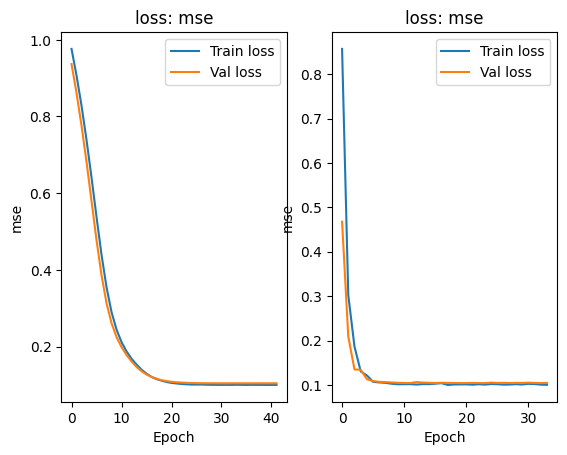

In [ ]:
## plot history
# ---------- best tuning ----------
plt.subplot(1, 2, 1)
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title(title_best, fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

# ---------- ranking #2 tuning ----------
plt.subplot(1, 2, 2)
plt.plot(history_top2.history['loss'])
plt.plot(history_top2.history['val_loss'])
plt.title(title_top2, fontsize=12)
plt.ylabel(ylabel_top2)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')


## Testing model

In [ ]:
y_pred = model_mse.predict(X_test)

1/1 [==============================] - 1s 577ms/step


In [ ]:
y_pred.shape

(16, 1, 180, 360)

In [ ]:
y_pred_reshaped = y_pred.reshape((y_test.shape[0], 180, 360))
y_test_reshaped= y_test.reshape((y_test.shape[0], 180, 360))

In [ ]:
y_pred_reshaped.shape

(16, 180, 360)

In [ ]:
y_test.shape

(16, 1, 180, 360)

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_reshaped[0], y_pred_reshaped[0])
print(f"R^2 Score: {r2}")

R^2 Score: 0.9339519284505788


In [ ]:
#Change of scale
y_test_original_scale = (y_test_reshaped * std2) + mean2
y_pred_original_scale = (y_pred_reshaped * std2) + mean2

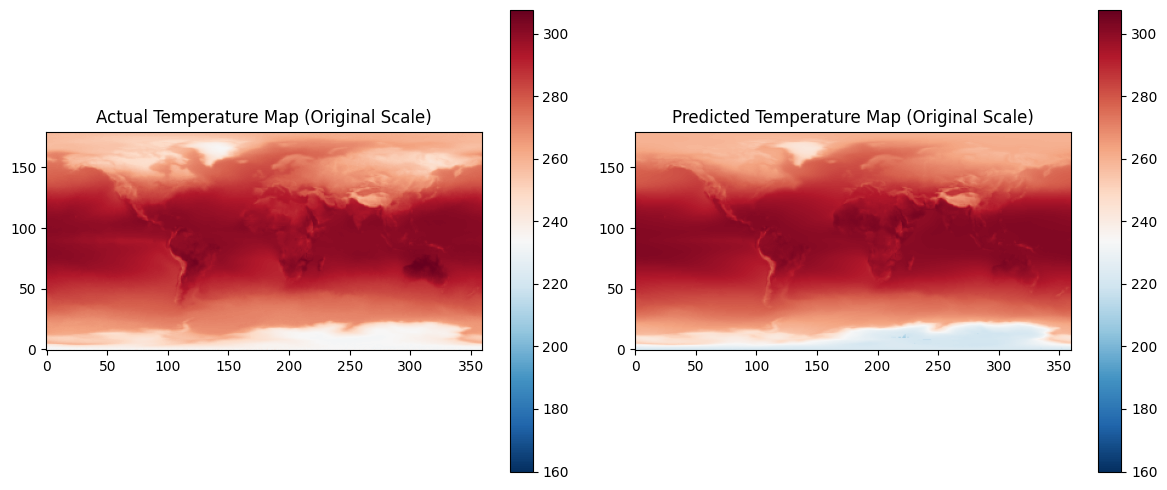

In [ ]:
import matplotlib.pyplot as plt

time_step_index = 0

# common color scale limits based on the actual data
common_vmin = min(y_test_original_scale[time_step_index].min(), y_pred_original_scale[time_step_index].min())
common_vmax = max(y_test_original_scale[time_step_index].max(), y_pred_original_scale[time_step_index].max())

# Plot actual temperature map
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(y_test_original_scale[time_step_index].reshape((180, 360)), cmap='RdBu_r', vmin=160, vmax=common_vmax)
plt.title('Actual Temperature Map (Original Scale)')
plt.gca().invert_yaxis()
plt.colorbar()

# Plot predicted temperature map
plt.subplot(1, 2, 2)
plt.imshow(y_pred_original_scale[time_step_index], cmap='RdBu_r', vmin=160, vmax=common_vmax)
plt.title('Predicted Temperature Map (Original Scale)')
plt.colorbar()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

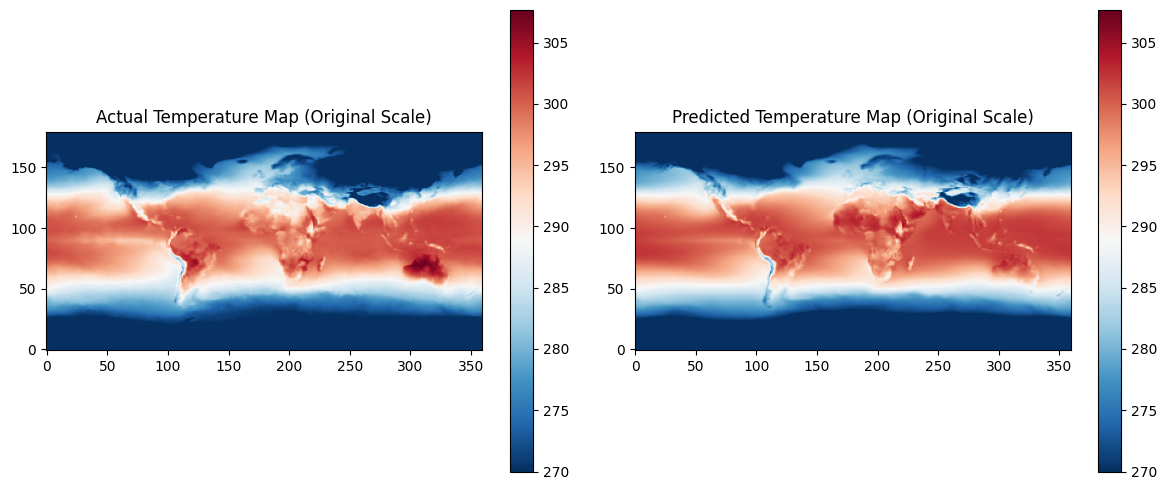

In [ ]:
import matplotlib.pyplot as plt

time_step_index = 0


# common color scale limits based on the actual data
common_vmin = min(y_test_original_scale[time_step_index].min(), y_pred_original_scale[time_step_index].min())
common_vmax = max(y_test_original_scale[time_step_index].max(), y_pred_original_scale[time_step_index].max())

# Plot actual temperature map
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(y_test_original_scale[time_step_index].reshape((180, 360)), cmap='RdBu_r', vmin=270, vmax=common_vmax)
plt.title('Actual Temperature Map (Original Scale)')
plt.gca().invert_yaxis()
plt.colorbar()

# Plot predicted temperature map
plt.subplot(1, 2, 2)
plt.imshow(y_pred_original_scale[time_step_index], cmap='RdBu_r', vmin=270, vmax=common_vmax)
plt.title('Predicted Temperature Map (Original Scale)')
plt.colorbar()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()